## Object Detection On Command
---

### Overview

This project will explore YOLO algorithm with Resnet50 using transfer learning, a method to use a pre-trained neural network and adapt the model to perform different tasks with different dataset, and design a model that is compatible with real-time video processing. PASCAL VOC (Visual Object Classes) 2012 dataset  will be in use of training models, and the model will be tested on real-time video data collected from webcams.


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Understand PASCAL VOC 2012 Data
* [Step 1](#step1): Data Pre-processing
* [Step 2](#step2): Model Architecture
* [Step 3](#step3): Loss Function
* [Step 4](#step4): Training
* [Step 5](#step5): -
* [Step 6](#step6): -
* [Step 7](#step7): -
* [Step 8](#step8): -
---
<a id='step0'></a>
## Step 0: Understand PASCAL VOC 2012 Data

### Combining annotation files into one CSV file

PASCAL VOC 2012 dataset has corresponding .xml file with annotation for each image jpg file.
Due to its complexity, we need to combine all these .xml files into one single csv file via panda modules.

First, let's sort all these xml files into one table.

In [1]:
anno_dir = "/home/ubuntu/VOCdevkit/VOC2012/Annotations/"
img_dir  = "/home/ubuntu/VOCdevkit/VOC2012/JPEGImages/"

In [2]:
import os 
import numpy as np
import xml.etree.ElementTree as ET
from collections import OrderedDict
import matplotlib.pyplot as plt
import pandas as pd 

def extracting_xml(tree):
    objN = 0
    row  = OrderedDict()
    for lines in tree.iter():
        
        if lines.tag == "size":
            for elem in lines:
                row[elem.tag] = int(elem.text)
                
        if lines.tag == "object":
            for elem in lines:
                if elem.tag == "name":
                    row["bbx_{}_{}".format(objN,elem.tag)] = str(elem.text)              
                if elem.tag == "bndbox":
                    for i in elem:
                        row["bbx_{}_{}".format(objN,i.tag)] = float(i.text)
                    objN += 1
    row["objN"] = objN
    return(row)

df_anno = []
for filename in os.listdir(anno_dir):  
    if not filename.startswith('.'): ## avoid hidden folders and files
        tree = ET.parse(os.path.join(anno_dir,filename))
        row = extracting_xml(tree)
        row["fileID"] = filename.split(".")[0]
        df_anno.append(row)
df_anno = pd.DataFrame(df_anno)

maxobjN = np.max(df_anno["objN"])

df_anno.head()

,width,height,depth,bbx_0_name,bbx_0_xmin,bbx_0_ymin,bbx_0_xmax,bbx_0_ymax,bbx_1_name,bbx_1_xmin,...,bbx_54_name,bbx_54_xmin,bbx_54_ymin,bbx_54_xmax,bbx_54_ymax,bbx_55_name,bbx_55_xmin,bbx_55_ymin,bbx_55_xmax,bbx_55_ymax
0,500,375,3,person,11.0,121.0,161.0,375.0,person,38.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,500,336,3,person,212.0,101.0,351.0,336.0,person,322.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,500,386,3,dog,170.0,138.0,339.0,271.0,chair,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,373,500,3,bird,130.0,132.0,258.0,320.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,329,500,3,person,101.0,175.0,249.0,325.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



---------------------------------
Save the table as a csv file.

In [3]:
# location to save df_anno.csv
csv_location = "/home/ubuntu/VOCdevkit/VOC2012"
df_anno.to_csv(os.path.join(csv_location,"df_anno.csv"),index=False)

### Setting the training - validation set

Training - Validation dataset is provided by PASCAL VOC 2012 datset. <br>
We're just going to read in the list of image file names.

Since each class has different number of data, the number of images in training and validation dataset does not represent the ratio of training - validation data.

Number of training images: 5717
Number of valid images: 5824
Number of trainval images: 11541
 
Example image:
height: 442  width: 500  color: 3


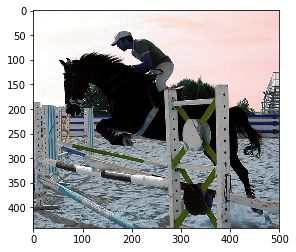

In [4]:
import cv2
import matplotlib.pyplot as plt

train_image_dir = "/home/ubuntu/VOCdevkit/VOC2012/ImageSets/Main/train.txt"
val_image_dir = "/home/ubuntu/VOCdevkit/VOC2012/ImageSets/Main/val.txt"
trainval_image_dir = "/home/ubuntu/VOCdevkit/VOC2012/ImageSets/Main/trainval.txt"
train_image_fnm = open(train_image_dir,"r").read().split('\n')
train_image_fnm.pop() #somehow, the last element is empty
val_image_fnm = open(val_image_dir,"r").read().split('\n')
trainval_image_fnm = open(trainval_image_dir,"r").read().split('\n')
print("Number of training images:", len(train_image_fnm))
print("Number of valid images:", len(val_image_fnm))
print("Number of trainval images:", len(trainval_image_fnm))
print(" ")
print("Example image:")

img=cv2.imread(img_dir + train_image_fnm[0]+".jpg")
h, w, c = img.shape
print ("height:",h," width:", w," color:", c)
plt.imshow(img)
plt.show()

### Achieving test data

In order to receive test data for PASCAL VOC 2012 Challenge, you need to go to [this site](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/#testdata)
<br>

Here, you have to register and download the test data in a .tar form.
After un-tarring this file (refer to ReadMe.md), place the folder in your VOC Devkit folder.

---
<a id='step1'></a>
## Step 1: Data Pre-processing

### Rescaling images to 416 * 416

CNN reads in pre-specified shape of images. For each image input, no matter what size they portrait, they will be encoded into (416, 416, 3). Meaning, they will be input as a form of 416 * 416 pixels with color. Parameters xmin, xmax, ymin, and ymax will be adjusted accordingly.

height: 416  width: 416  color: 3


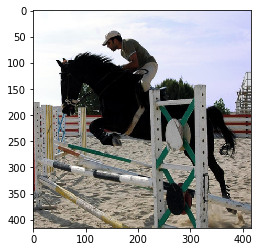

In [5]:
def rescale_img(new_h, new_w, path):
    image=cv2.imread(path)
    image=cv2.resize(image,(new_h, new_w))
    image = image[:,:,::-1] #re-ordering rgb
    image = image/255 #normalizing
    
    return image

new_h = 416 #new height of the resized image
new_w = 416 #new width of the resized image


path = img_dir + train_image_fnm[0]+".jpg"
image = rescale_img(new_h, new_w, path)


h, w, c = image.shape
print ("height:",h," width:", w," color:", c)
plt.imshow(image)
plt.show()

### Creating another dataframe with rescaled images

In [6]:
rescaled_anno = df_anno.copy()
rescaled_anno.head()

,width,height,depth,bbx_0_name,bbx_0_xmin,bbx_0_ymin,bbx_0_xmax,bbx_0_ymax,bbx_1_name,bbx_1_xmin,...,bbx_54_name,bbx_54_xmin,bbx_54_ymin,bbx_54_xmax,bbx_54_ymax,bbx_55_name,bbx_55_xmin,bbx_55_ymin,bbx_55_xmax,bbx_55_ymax
0,500,375,3,person,11.0,121.0,161.0,375.0,person,38.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,500,336,3,person,212.0,101.0,351.0,336.0,person,322.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,500,386,3,dog,170.0,138.0,339.0,271.0,chair,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,373,500,3,bird,130.0,132.0,258.0,320.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,329,500,3,person,101.0,175.0,249.0,325.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Adjust the bounding boxes accordingly
<br>
Not only changing the width and height of images, we also have to change the bounding boxes of images.<br><br>
<b>(xmin or xmax) / (original width) = (new xmin or xmax) / (new width = 416)<br>
(ymin or ymax) / (original height) = (new ymin or ymax) / (new height = 416)</b>

In [7]:
for N in range(0,maxobjN):    
    for cr in ['xmin', 'xmax']:
        self = rescaled_anno["bbx_{}_{}".format(N,cr)].copy()
        rescaled_anno["bbx_{}_{}".format(N,cr)] = self * new_w / df_anno["width"]
    for cr in ['ymin', 'ymax']:
        self = rescaled_anno["bbx_{}_{}".format(N,cr)].copy()
        rescaled_anno["bbx_{}_{}".format(N,cr)] = self * new_h / df_anno["height"]

rescaled_anno["width"] = new_w
rescaled_anno["height"] = new_h
rescaled_anno.head()

,width,height,depth,bbx_0_name,bbx_0_xmin,bbx_0_ymin,bbx_0_xmax,bbx_0_ymax,bbx_1_name,bbx_1_xmin,...,bbx_54_name,bbx_54_xmin,bbx_54_ymin,bbx_54_xmax,bbx_54_ymax,bbx_55_name,bbx_55_xmin,bbx_55_ymin,bbx_55_xmax,bbx_55_ymax
0,416,416,3,person,9.152000,134.229333,133.952000,416.000000,person,31.616,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,416,416,3,person,176.384000,125.047619,292.032000,416.000000,person,267.904,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,416,416,3,dog,141.440000,148.725389,282.048000,292.062176,chair,0.832,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,416,416,3,bird,144.986595,109.824000,287.742627,266.240000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,416,416,3,person,127.708207,145.600000,314.844985,270.400000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Visualization of rescaled images

Here, I will show how bounding boxes have resized and relocated according to newly scaled images.

In [8]:
import imageio
def plt_rectangle(plt,label,x1,y1,x2,y2):
    '''
    == Input ==
    
    plt   : matplotlib.pyplot object
    label : string containing the object class name
    x1    : top left corner x coordinate
    y1    : top left corner y coordinate
    x2    : bottom right corner x coordinate
    y2    : bottom right corner y coordinate
    '''
    linewidth = 1
    color = "yellow"
    plt.text(x1,y1,label,fontsize=10,backgroundcolor="magenta")
    plt.plot([x1,x1],[y1,y2], linewidth=linewidth,color=color)
    plt.plot([x2,x2],[y1,y2], linewidth=linewidth,color=color)
    plt.plot([x1,x2],[y1,y1], linewidth=linewidth,color=color)
    plt.plot([x1,x2],[y2,y2], linewidth=linewidth,color=color)
    

    
    
plt.imshow(image) # plot image
df = rescaled_anno.loc[rescaled_anno['fileID']==train_image_fnm[0]] 
row_num = int(df.index.values)
print(row_num)
df.head()


870


,width,height,depth,bbx_0_name,bbx_0_xmin,bbx_0_ymin,bbx_0_xmax,bbx_0_ymax,bbx_1_name,bbx_1_xmin,...,bbx_54_name,bbx_54_xmin,bbx_54_ymin,bbx_54_xmax,bbx_54_ymax,bbx_55_name,bbx_55_xmin,bbx_55_ymin,bbx_55_xmax,bbx_55_ymax
870,416,416,3,horse,44.096,81.882353,391.872,395.294118,person,131.456,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


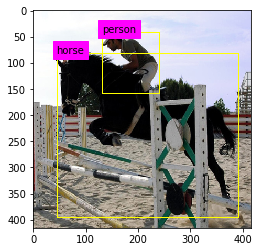

In [9]:
plt.imshow(image) # plot image

# for each object in the image, plot the bounding box
for iplot in range(df.at[row_num,"objN"]):
    plt_rectangle(plt,
                  label = df.at[row_num,"bbx_{}_name".format(iplot)],
                  x1=df.at[row_num,"bbx_{}_xmin".format(iplot)],
                  y1=df.at[row_num,"bbx_{}_ymin".format(iplot)],
                  x2=df.at[row_num,"bbx_{}_xmax".format(iplot)],
                  y2=df.at[row_num,"bbx_{}_ymax".format(iplot)])
plt.show() ## show the plot

### Bounding Box Encoding

<br>
So far, we have been plotting out bounding boxes based on the coordinates provided by the PASCAL VOC 2012 dev kit, which is formatted as below: <br><br>
<b>{bbx_n_name,bbx_n_xmin,bbx_n_ymin,bbx_n_xmax,bbx_n_ymax}</b>

However, the algorithm we will use require different format of bounding box coordinates which can be described as below:
<b>{bbx_n_name,bbx_n_center_x,bbx_n_center_y,bbx_n_center_w,bbx_n_center_h}</b><br><br>
The transformation will take place as explained in the image below (from [Yumi's blog](https://fairyonice.github.io/Part%202_Object_Detection_with_Yolo_using_VOC_2014_data_input_and_output_encoding.html#Output-encoding-2:)):<br>
</html>
<img src="images/boundingbox_datatransform.png" alt="Drawing" style="width: 400px;"/>
</html>


Let's rename the coulmn names first!

In [10]:
transformed_anno = rescaled_anno.copy()
#old column names
old_col_nms_xmin=[]
old_col_nms_ymin=[]
old_col_nms_xmax=[]
old_col_nms_ymax=[]
#new column names
new_col_nms_xmin=[]
new_col_nms_ymin=[]
new_col_nms_xmax=[]
new_col_nms_ymax=[]

for i in range(maxobjN):
    old_col_nms_xmin.append("bbx_{}_xmin".format(i))
    old_col_nms_ymin.append("bbx_{}_ymin".format(i))
    old_col_nms_xmax.append("bbx_{}_xmax".format(i))
    old_col_nms_ymax.append("bbx_{}_ymax".format(i))
    new_col_nms_xmin.append("bbx_{}_center_x".format(i))
    new_col_nms_ymin.append("bbx_{}_center_y".format(i))
    new_col_nms_xmax.append("bbx_{}_center_w".format(i))
    new_col_nms_ymax.append("bbx_{}_center_h".format(i))

transformed_anno.rename(columns=dict(zip(old_col_nms_xmin, new_col_nms_xmin)), inplace=True)
transformed_anno.rename(columns=dict(zip(old_col_nms_ymin, new_col_nms_ymin)), inplace=True)
transformed_anno.rename(columns=dict(zip(old_col_nms_xmax, new_col_nms_xmax)), inplace=True)
transformed_anno.rename(columns=dict(zip(old_col_nms_ymax, new_col_nms_ymax)), inplace=True)


transformed_anno.head()

,width,height,depth,bbx_0_name,bbx_0_center_x,bbx_0_center_y,bbx_0_center_w,bbx_0_center_h,bbx_1_name,bbx_1_center_x,...,bbx_54_name,bbx_54_center_x,bbx_54_center_y,bbx_54_center_w,bbx_54_center_h,bbx_55_name,bbx_55_center_x,bbx_55_center_y,bbx_55_center_w,bbx_55_center_h
0,416,416,3,person,9.152000,134.229333,133.952000,416.000000,person,31.616,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,416,416,3,person,176.384000,125.047619,292.032000,416.000000,person,267.904,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,416,416,3,dog,141.440000,148.725389,282.048000,292.062176,chair,0.832,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,416,416,3,bird,144.986595,109.824000,287.742627,266.240000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,416,416,3,person,127.708207,145.600000,314.844985,270.400000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Our algorithm will divide each image into grids and process image classification and localization for each grid cell.<br>
For this, we have to rescale the coordinates assuming the side length of each grid cell being 1.

In [11]:
grid_w = 13
grid_h = 13

for i in range(maxobjN):
    #center_x = 0.5*(xmin+xmax), center_y = 0.5*(ymin+ymax)
    #center_w = xmax - xmin, center_h = ymax - ymin
    center_x=0.5*(rescaled_anno["bbx_{}_xmin".format(i)]+rescaled_anno["bbx_{}_xmax".format(i)])
    center_y=0.5*(rescaled_anno["bbx_{}_ymin".format(i)]+rescaled_anno["bbx_{}_ymax".format(i)])
    center_w=rescaled_anno["bbx_{}_xmax".format(i)]-rescaled_anno["bbx_{}_xmin".format(i)]
    center_h=rescaled_anno["bbx_{}_ymax".format(i)]-rescaled_anno["bbx_{}_ymin".format(i)]
    
    #Rescaling the coordinates assuming the side length of each grid cell being 1.
    transformed_anno["bbx_{}_center_x".format(i)]=center_x/(float(new_w))*grid_w
    transformed_anno["bbx_{}_center_y".format(i)]=center_y/(float(new_h))*grid_h
    transformed_anno["bbx_{}_center_w".format(i)]=center_w/(float(new_w))*grid_w
    transformed_anno["bbx_{}_center_h".format(i)]=center_h/(float(new_h))*grid_h

transformed_anno.head()

,width,height,depth,bbx_0_name,bbx_0_center_x,bbx_0_center_y,bbx_0_center_w,bbx_0_center_h,bbx_1_name,bbx_1_center_x,...,bbx_54_name,bbx_54_center_x,bbx_54_center_y,bbx_54_center_w,bbx_54_center_h,bbx_55_name,bbx_55_center_x,bbx_55_center_y,bbx_55_center_w,bbx_55_center_h
0,416,416,3,person,2.236000,8.597333,3.900000,8.805333,person,3.003,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,416,416,3,person,7.319000,8.453869,3.614000,9.092262,person,9.880,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,416,416,3,dog,6.617000,6.887306,4.394000,4.479275,chair,2.340,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,416,416,3,bird,6.761394,5.876000,4.461126,4.888000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,416,416,3,person,6.914894,6.500000,5.848024,3.900000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Preparing CSV files for training and validation dataset

In order to train our model, we will prepare two different csv files; one contains data of training images with rescaled annotations and the other contains those of validation images also with rescaled annotations.
These two data will be extracted from the original csv file that contains information for all the images in our datset by matching the fileID.

In [12]:
train_df=transformed_anno.loc[transformed_anno['fileID'].isin(train_image_fnm)]
print("The number of images in our training dataframe: ",train_df.shape[0])
print("The number of file names from train.txt: ", len(train_image_fnm))
val_df=transformed_anno.loc[transformed_anno['fileID'].isin(val_image_fnm)]
print("The number of images in our validation dataframe: ",val_df.shape[0])
print("The number of file names from val.txt: ", len(val_image_fnm))


The number of images in our training dataframe:  5717
The number of file names from train.txt:  5717
The number of images in our validation dataframe:  5823
The number of file names from val.txt:  5824


Let's save those dataframes into csv files.

In [13]:
# location to save df_anno.csv
csv_location = "/home/ubuntu/VOCdevkit/VOC2012"
train_df.to_csv(os.path.join(csv_location,"train_df.csv"),index=False)
val_df.to_csv(os.path.join(csv_location,"val_df.csv"),index=False)

---
<a id='step2'></a>
## Step 2: Batch Generator


This batch generator is fairly a simple model. 
It shuffles the list of images from the train_df dataframe and produces output: x_batch and y_batch.<br><br>
x_batch = (batch_size, rescaled_image_height = 416, rescaled_image_width = 416, channel =3)<br>
y_batch = (batch_size, grid_height = 13, grid_width =13, 4 + 1 + Number of Classes)<br><br>

x_batch is composed of rescaled images.<br>
y_batch contains information about <br>
* Where the boxes are
* Existence of an object
* Classification of the object

y_batch(,,,0:4)       =  (center_x, center_y, center_w, center_h)<br>
y_batch(,,,4)         =  1 if (an object exists), 0 else <br>
y_batch(,,,5+iClass)  =  kinda like one-hot encoding with classes. <br>
    &nbsp;&nbsp;&nbsp;&nbsp;i.g. if there is an aeroplane, aeroplane being the first class among the list, y_batch(,,,5+0) will be 1

In [14]:
LABELS = ['aeroplane',  'bicycle', 'bird',  'boat',      'bottle', 
          'bus',        'car',      'cat',  'chair',     'cow',
          'diningtable','dog',    'horse',  'motorbike', 'person',
          'pottedplant','sheep',  'sofa',   'train',   'tvmonitor']

In [15]:
from keras.utils import Sequence

class BatchGenerator(Sequence):
    def __init__(self, df, batch_size, grid_h, grid_w, LABELS, shuffle=True):
        self.batch_size = batch_size
        self.LABELS = LABELS
        self.CLASS = len(self.LABELS)
        self.grid_h = grid_h
        self.grid_w = grid_w
        self.df = df.copy()
        self.shuffle = shuffle
        if self.shuffle: 
            self.df = self.df.sample(frac=1).reset_index(drop=True)
            
    def __len__(self):
        return int(np.ceil(float(self.df.shape[0])/self.batch_size))  
    
    def __getitem__(self, idx):
        
        l_bound = idx*self.batch_size
        r_bound = (idx+1)*self.batch_size

        if r_bound > self.df.shape[0]:
            r_bound = self.df.shape[0]
            l_bound = r_bound - self.batch_size
        
        ##initiate the instance for the output batch
        instance_cnt = 0
        
        ## empty storage space
        x_batch = np.zeros((self.batch_size, self.df["height"][0], self.df["width"][0], 3)) # input images
        #b_batch = np.zeros((self.batch_size, 1     , 1   , 4))   # bounding boxes
        y_batch = np.zeros((self.batch_size, self.grid_h,  self.grid_w , 4+1+self.CLASS)) # network output
        
        # ** 4 + 1 + self.CLASS **
        # * 4 => center_x, center_y, center_w, center_h of bounding boxes
        # * 1 = > either there is an object or not 
        # * CLASS => one hot encoding for class labels
        

        for index, row in self.df.loc[l_bound:r_bound-1].iterrows():  
            
            ##each object's bounding box index, reset every row
            box_index = 0
            #print ("First Loop= index:", index)
            #print("Second Loop = objN: ", row["objN"] )
            for obj in range(row["objN"]):
                
                center_x = row["bbx_{}_center_x".format(obj)]
                center_y = row["bbx_{}_center_y".format(obj)]
                center_w = row["bbx_{}_center_w".format(obj)]
                center_h = row["bbx_{}_center_h".format(obj)]
                
                ##At which grid is the object located?
                grid_x = int(np.floor(center_x))
                grid_y = int(np.floor(center_y))
                #What is the object? - kinda like one-hot encoding
                obj_idx  = self.LABELS.index(row["bbx_{}_name".format(obj)])
                
                
                ##Output of the generator - y_batch
                box = [center_x, center_y, center_w, center_h]
                y_batch[instance_cnt, grid_y, grid_x, 0:4] = box 
                y_batch[instance_cnt, grid_y, grid_x, 4  ] = 1. # ground truth confidence = 1
                y_batch[instance_cnt, grid_y, grid_x, 5+obj_idx] = 1 # class probability of the object
                
                ##Another output for bounding boxes from the generator - b_batch
                #b_batch[instance_cnt, 0, 0, box_index] = box
                box_index += 1
                #print("obj =",obj) 
            ## Which image are these all about? - xbatch
            img_path = "/home/ubuntu/VOCdevkit/VOC2012/JPEGImages/"+row["fileID"]+".jpg"
            x_batch[instance_cnt] = rescale_img(self.df["height"][0], self.df["width"][0], img_path)
            ## increase instance counter
            
            #print("instance_cnt: ",instance_cnt)
            #print("")
            instance_cnt += 1
        #return [x_batch, b_batch], y_batch
        return x_batch, y_batch

    def on_epoch_end(self):
        if self.shuffle: 
            self.df = self.df.sample(frac=1).reset_index(drop=True)

Using TensorFlow backend.


Below is a debugging process of this generator with an index of 3.

In [16]:
train_batch_generator = BatchGenerator(train_df, batch_size =32, grid_h=grid_h, grid_w=grid_w, LABELS=LABELS, shuffle=True)

#[x_batch,b_batch],y_batch = train_batch_generator.__getitem__(idx=3)
x_batch,y_batch = train_batch_generator.__getitem__(idx=10)

In [17]:
print("x_batch shape:", x_batch.shape)
print("y_batch shape:", y_batch.shape)

x_batch shape: (32, 416, 416, 3)
y_batch shape: (32, 13, 13, 25)


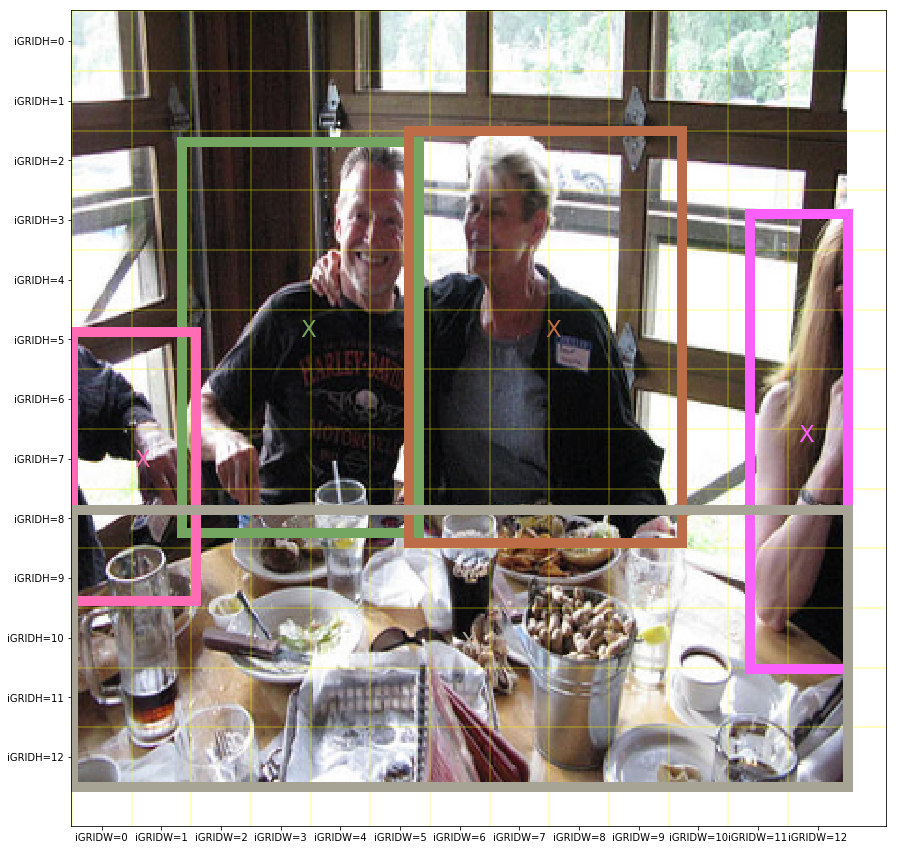

In [18]:
def plot_image_with_grid_cell_partition(irow):
    img = x_batch[irow]
    plt.figure(figsize=(15,15))
    plt.imshow(img)
    for wh in ["W","H"]:
        GRID_       = 13 ## 13
        IMAGE_      = 416 ## 416
        if wh == "W":
            pltax   = plt.axvline
            plttick = plt.xticks
        else:
            pltax   = plt.axhline
            plttick = plt.yticks
            
        for count in range(GRID_):
            l = IMAGE_*count/GRID_
            pltax(l,color="yellow",alpha=0.3) 
        plttick([(i + 0.5)*IMAGE_/GRID_ for i in range(GRID_)],
                ["iGRID{}={}".format(wh,i) for i in range(GRID_)])

def plot_grid(irow):
    import seaborn as sns
    color_palette = list(sns.xkcd_rgb.values())
    iobj = 0
    for igrid_h in range(GRID_H):
        for igrid_w in range(GRID_W):
           
            vec = y_batch[irow,igrid_h,igrid_w,:]
            C = vec[4] ## ground truth confidence
            if C == 1:
                class_nm = np.array(LABELS)[np.where(vec[5:])]
                x, y, w, h = vec[:4]
                multx = IMAGE_W/GRID_W
                multy = IMAGE_H/GRID_H
                c = color_palette[iobj]
                iobj += 1
                xmin = x - 0.5*w
                ymin = y - 0.5*h
                xmax = x + 0.5*w
                ymax = y + 0.5*h
                # center
                plt.text(x*multx,y*multy,
                            "X",color=c,fontsize=23)
                plt.plot(np.array([xmin,xmin])*multx,
                            np.array([ymin,ymax])*multy,color=c,linewidth=10)
                plt.plot(np.array([xmin,xmax])*multx,
                            np.array([ymin,ymin])*multy,color=c,linewidth=10)
                plt.plot(np.array([xmax,xmax])*multx,
                            np.array([ymax,ymin])*multy,color=c,linewidth=10)  
                plt.plot(np.array([xmin,xmax])*multx,
                            np.array([ymax,ymax])*multy,color=c,linewidth=10)

iframe=3
IMAGE_W, IMAGE_H =(416,416)
GRID_W, GRID_H =(13,13)
plot_image_with_grid_cell_partition(iframe)
plot_grid(iframe)
plt.show()

---
<a id='step2'></a>
## Step 2: Model Architecture

### Base Model : Resnet50



In [19]:
from keras.applications import ResNet50
from keras.layers import Input
input_image = Input(shape=x_batch.shape[1:],name="input_image")

base_model= ResNet50(include_top=False,weights='imagenet',input_shape= x_batch.shape[1:])

base_model.trainable = False

base_model.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 416, 416, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 208, 208, 64)  9472        input_1[0][0]                    
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 208, 208, 64)  256         conv1[0][0]                      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 208, 208, 64)  0           bn_conv1[0][0]                   
___________________________________________________________________________________________

### Transfer Learning

In [20]:
from keras.models import Sequential, Model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda, Dropout, SpatialDropout2D
from backend import ConvBatchLReLu

#Code by George Seif: https://towardsdatascience.com/transfer-learning-for-image-classification-using-keras-c47ccf09c8c8

def build_finetune_model(base_model, num_classes):
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.layers[-2].output
    print(x.shape)
    #First trainable layer
    x = Conv2D (1024, (5,5), strides=(1,1), padding='same', name='trans_conv_1')(x)
    #x = SpatialDropout2D (dropout)
    x = BatchNormalization(name='trans_norm_1', trainable=True)(x)
    print(x.shape)
    #Second trainable layer
    x = Conv2D (512, (3,3), strides=(1,1), padding='same', name='trans_conv_2')(x)
    #x = SpatialDropout2D (dropout)
    x = BatchNormalization(name='trans_norm_2', trainable=True)(x)
    print(x.shape)
    #Third trainable layer
    x = Conv2D (256, (3,3), strides=(1,1), padding='same', name='trans_conv_3')(x)
    #x = SpatialDropout2D (dropout)
    x = BatchNormalization(name='trans_norm_3', trainable=True)(x)
    print(x.shape)
    #Final trainable layer
    output = Conv2D (1+4+num_classes, (1,1), strides=(1,1), padding='same', name='trans_conv_4')(x)
    print(x.shape)   
    
    
    finetune_model = Model(inputs=base_model.input, outputs=output)

    return finetune_model


finetune_model = build_finetune_model(base_model,   
                                      num_classes=len(LABELS))
finetune_model.summary()


(?, 13, 13, 2048)
(?, 13, 13, 1024)
(?, 13, 13, 512)
(?, 13, 13, 256)
(?, 13, 13, 256)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 416, 416, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 208, 208, 64)  9472        input_1[0][0]                    
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 208, 208, 64)  256         conv1[0][0]                      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 208, 208, 64)  0           bn_conv1[0][0]                   
____

### Initialize Weights

In [21]:
def initialize_weight(layer,sd):
    weights = layer.get_weights()
    kernel = np.random.normal(size=weights[0].shape, scale=sd)
    bias   = np.random.normal(size=weights[1].shape, scale=sd)
    layer.set_weights([kernel, bias])

grid_h=13
grid_w=13

#initializing all the conv2d laver I added.
for i in range(-1, -8, -2):
    print(i)
    layer = finetune_model.layers[i]
    initialize_weight(layer,sd=grid_h*grid_w)


-1
-3
-5
-7


---
<a id='step3'></a>
## Step 3: Loss Function

Our loss function will deal with two tasks: classification and localization.<br>
This will produce two factors, loss_bbx and loss_class, which will be summed to get the final loss.<br>
loss_bbx measures how close the predicted boxes are to the true boxes.<br>
loss_class measures how correct the classification of an object has been made using softmax cross entropy.<br>

Below is how the final loss function will look.

<b>def custom_loss (y_true, y_pred):</b>
    
    #Get Prediction
    pred_xy, pred_wy, pred_conf, pred_class = get_prediction (y_pred)
    
    #Extract Truth
    true_xy, true_wy, true_conf, true_class = get_truth (y_true)
    
    #Calculate loss for bounding boxes using *IOU
    loss_bbx = calc_loss_bbx (true_xy, true_wh, pred_xy, pred_wh, true_conf)
    
    #Calculate loss for classification
    loss_class = calc_loss_class (true_class, pred_class, true_conf)
    
    
    
    loss = loss_bbx + loss_class 
    
    return loss

### Get Prediction

In [22]:
import tensorflow as tf

#Since we are dividing images into grids, we need an additional function.
def get_cell_grid(GRID_W,GRID_H,BATCH_SIZE): 
    
    cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1)))
    cell_y = tf.transpose(cell_x, (0,2,1,3)) 
    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, 1])
    
    return cell_grid

def get_prediction(y_pred, cell_grid):
    
    pred_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid
    #tf.exp to get rid of negatives; -0.5 to set the value in the range of [0,grid_wh = 13]
    pred_wh = tf.exp(y_pred[..., 2:4]) + cell_grid - 0.5 
    
  
    pred_conf = tf.sigmoid(y_pred[..., 4])
    pred_class = y_pred[..., 5:]
    
    return(pred_xy,pred_wh,pred_conf,pred_class)

#### Overview of the predicted data

In order to show you the overview of the prediction, codes from [experiencor's github](https://github.com/experiencor/keras-yolo2/blob/master/Yolo%20Step-by-Step.ipynb) were modified to match our calculation. <br>


In [23]:
def print_min_max(vec,title):
    #if not vec.any():
    #    print("{} MIN={}, MAX={}".format(
    #    title,"0.00","0.00"))
    #else:
        print("{} MIN={:5.2f}, MAX={:5.2f}".format(
        title,np.min(vec),np.max(vec)))

print("*"*30)
print("prepare inputs")
BATCH_SIZE = 32
GRID_W = 13 
GRID_H = 13 
CLASS = len(LABELS)
size   = BATCH_SIZE*GRID_W*GRID_H*(4 + 1 + CLASS)
y_pred = np.random.normal(size=size,scale = 10/(GRID_H*GRID_W)) 
y_pred = y_pred.reshape(BATCH_SIZE,GRID_H,GRID_W,4 + 1 + CLASS)
print("y_pred before scaling = {}".format(y_pred.shape))

print("*"*30)
print("define tensor graph")
y_pred_tf = tf.constant(y_pred,dtype="float32")
cell_grid = get_cell_grid(GRID_W = GRID_W,GRID_H = GRID_H,BATCH_SIZE =32)

(pred_box_xy_tf,   pred_box_wh_tf, 
 pred_box_conf_tf, pred_box_class_tf) = get_prediction(y_pred_tf, cell_grid)
print("*"*30 + "\nouput\n" + "*"*30) 
with tf.Session() as sess:
    (pred_box_xy,   pred_box_wh, 
     pred_box_conf, pred_box_class) = sess.run(
        [pred_box_xy_tf,   pred_box_wh_tf,
         pred_box_conf_tf, pred_box_class_tf])
    
print("\npred_box_xy {}".format(pred_box_xy.shape))           
for igrid_w in range(pred_box_xy.shape[2]):
        print_min_max(pred_box_xy[:,:,igrid_w,0].flatten(),
                      "  bounding box x at iGRID_W={:02.0f}".format(igrid_w))
for igrid_h in range(pred_box_xy.shape[1]):
    print_min_max(pred_box_xy[:,igrid_h,:,1].flatten(),
                  "  bounding box y at iGRID_H={:02.0f}".format(igrid_h)) 
    
print("\npred_box_wh {}".format(pred_box_wh.shape))
print_min_max(pred_box_wh[:,:,:,0].flatten(),"  bounding box width ") 
print_min_max(pred_box_wh[:,:,:,1].flatten(),"  bounding box height") 
    
print("\npred_box_conf {}".format(pred_box_conf.shape))
print_min_max(pred_box_conf.flatten(),"  confidence ") 

print("\npred_box_class {}".format(pred_box_class.shape))
print_min_max(pred_box_class.flatten(),"  class probability") 

******************************
prepare inputs
y_pred before scaling = (32, 13, 13, 25)
******************************
define tensor graph
******************************
ouput
******************************

pred_box_xy (32, 13, 13, 2)
  bounding box x at iGRID_W=00 MIN= 0.46, MAX= 0.55
  bounding box x at iGRID_W=01 MIN= 1.47, MAX= 1.54
  bounding box x at iGRID_W=02 MIN= 2.45, MAX= 2.55
  bounding box x at iGRID_W=03 MIN= 3.46, MAX= 3.54
  bounding box x at iGRID_W=04 MIN= 4.45, MAX= 4.54
  bounding box x at iGRID_W=05 MIN= 5.46, MAX= 5.55
  bounding box x at iGRID_W=06 MIN= 6.46, MAX= 6.54
  bounding box x at iGRID_W=07 MIN= 7.46, MAX= 7.56
  bounding box x at iGRID_W=08 MIN= 8.46, MAX= 8.54
  bounding box x at iGRID_W=09 MIN= 9.45, MAX= 9.54
  bounding box x at iGRID_W=10 MIN=10.44, MAX=10.55
  bounding box x at iGRID_W=11 MIN=11.46, MAX=11.55
  bounding box x at iGRID_W=12 MIN=12.44, MAX=12.55
  bounding box y at iGRID_H=00 MIN= 0.45, MAX= 0.54
  bounding box y at iGRID_H=01 MIN= 1

### Extract Truth

In [24]:
def get_truth(y_true):
    true_xy = y_true[...,0:2]
    true_wh = y_true[...,2:4]
    true_conf = y_true[...,4]
    true_class = tf.argmax(y_true[..., 5:], -1)
    return(true_xy, true_wh, true_conf, true_class)

#### Overview of the ground truth

In order to show you the overview of the ground truth data, codes from [experiencor's github](https://github.com/experiencor/keras-yolo2/blob/master/Yolo%20Step-by-Step.ipynb) were modified to match our calculation. <br>

In [30]:
import numpy as np
# y_batch is the output of the simpleBatchGenerator.fit()
print("Input y_batch = {}".format(y_batch.shape))

y_batch_tf = tf.constant(y_batch,dtype="float32")
(true_box_xy_tf, true_box_wh_tf, 
 true_box_conf_tf, true_box_class_tf) = get_truth(y_batch_tf)

print("*"*30 + "\nouput\n" + "*"*30) 

with tf.Session() as sess:
        (true_box_xy, true_box_wh, 
         true_box_conf, true_box_class) = sess.run(
                    [true_box_xy_tf,   true_box_wh_tf, 
                     true_box_conf_tf, true_box_class_tf])

print("\ntrue_box_xy {}".format(true_box_xy.shape))        
for igrid_w in range(true_box_xy.shape[2]):
    vec  = true_box_xy[:,:,igrid_w,0].flatten()
    pick = true_box_conf[:,:,igrid_w].flatten() == 1
    bruh = vec[pick]
    if not bruh.any():
        bruh = np.zeros((416,), dtype = int)
        
    print_min_max(bruh,"  bounding box x at iGRID_W={:02.0f}".format(igrid_w))
    
for igrid_h in range(true_box_xy.shape[1]):
    vec  = true_box_xy[:,igrid_h,:,1].flatten()
    pick = true_box_conf[:,igrid_h,:].flatten() == 1
    bruh = vec[pick]
    if not bruh.any():
        bruh = np.zeros((416,), dtype = int)
    print_min_max(bruh,"  bounding box y at iGRID_H={:02.0f}".format(igrid_h)) 
    
print("\ntrue_box_wh {}".format(true_box_wh.shape))
print_min_max(true_box_wh[:,:,:,0].flatten(),"  bounding box width ") 
print_min_max(true_box_wh[:,:,:,1].flatten(),"  bounding box height") 
  
print("\ntrue_box_conf {}".format(true_box_conf.shape))
print("  confidence, unique value = {}".format(np.unique(true_box_conf.flatten()))) 

print("\ntrue_box_class {}".format(true_box_class.shape))
print("  class index, unique value = {}".format(np.unique(true_box_class.flatten())) )

Input y_batch = (32, 13, 13, 25)
******************************
ouput
******************************

true_box_xy (32, 13, 13, 2)
  bounding box x at iGRID_W=00 MIN= 0.46, MAX= 0.99
  bounding box x at iGRID_W=01 MIN= 1.01, MAX= 1.27
  bounding box x at iGRID_W=02 MIN= 2.05, MAX= 2.99
  bounding box x at iGRID_W=03 MIN= 3.35, MAX= 3.84
  bounding box x at iGRID_W=04 MIN= 4.19, MAX= 4.89
  bounding box x at iGRID_W=05 MIN= 5.29, MAX= 5.95
  bounding box x at iGRID_W=06 MIN= 6.19, MAX= 6.97
  bounding box x at iGRID_W=07 MIN= 7.02, MAX= 7.93
  bounding box x at iGRID_W=08 MIN= 8.02, MAX= 8.90
  bounding box x at iGRID_W=09 MIN= 9.46, MAX= 9.83
  bounding box x at iGRID_W=10 MIN=10.26, MAX=10.84
  bounding box x at iGRID_W=11 MIN=11.39, MAX=11.69
  bounding box x at iGRID_W=12 MIN=12.18, MAX=12.33
  bounding box y at iGRID_H=00 MIN= 0.43, MAX= 0.43
  bounding box y at iGRID_H=01 MIN= 0.00, MAX= 0.00
  bounding box y at iGRID_H=02 MIN= 2.10, MAX= 2.81
  bounding box y at iGRID_H=03 MIN= 3.

### Calculate loss for bounding boxes (IOU)

#### What is *Intersection Over Union (IOU)?


IOU is an evaluation metric for object detectioin task. Algorithms that output predicted bounding boxes can make use of this metric. <br>This metric system measures how much a predicted bounding box overlaps with a ground truth bounding box.<br>
More insightful explanation of the metric is given below from [Adrian Rosebrock's article](https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/).

</html>
<img src="images/iou_equation.png" alt="Drawing" style="width: 300px;"/>
</html>

In [39]:
def get_iou(true_xy, true_wh, pred_xy, pred_wh):
    
    true_mins = true_xy - (0.5*true_wh)
    true_maxes = true_xy + (0.5*true_wh)
    pred_mins = pred_xy - (0.5*pred_wh)
    pred_maxes = pred_xy + (0.5*pred_wh)
    
    inter_maxes = tf.minimum(true_maxes, pred_maxes)
    inter_mins = tf.maximum(true_mins, pred_mins)
    inter_wh = tf.maximum(inter_maxes - inter_mins, 0.)
    inter_area = inter_wh[...,0] * inter_wh[...,1]
    
    union_area = (true_xy[...,0]*true_xy[...,1]) + (pred_xy[...,0]*pred_xy[...,1]) - inter_area
    iou = tf.truediv (inter_area, union_area + 1e-6)
    

    return iou

In [40]:
def calc_loss_bbx(true_xy, true_wh, pred_xy, pred_wh, true_conf):
    
    
    loss_bbx = get_iou(true_xy, true_wh, pred_xy, pred_wh)
    n_bbx = tf.reduce_sum(tf.to_float(true_conf > 0.0))
    loss_bbx = tf.reduce_sum(loss_bbx) / (n_bbx+1e-6)
    
    return loss_bbx


def calc_loss_class(true_class, pred_class, true_conf):
    
    
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_class, logits=pred_class)
    n_class_box = tf.reduce_sum(tf.to_float(true_conf > 0.0))
    
    loss_class = tf.reduce_sum(loss_class * true_conf)/(n_class_box+1e-6)
    
    return loss_class
    

#### Testing loss function

We will test our loss function by getting truth from our batch generator and prediction from NumPy random number generator.

In [41]:
#Ground Truth From Batch Generator
y_batch_tf = tf.constant(y_batch,dtype="float32")
#Random Prediction
size   = BATCH_SIZE*GRID_W*GRID_H*(4 + 1 + CLASS)
y_pred = np.random.normal(size=size,scale = 10/(GRID_H*GRID_W)) 
y_pred = y_pred.reshape(BATCH_SIZE,GRID_H,GRID_W,4 + 1 + CLASS)
y_pred_tf = tf.constant(y_pred,dtype="float32")

(true_xy_test, true_wh_test, 
 true_conf_test, true_class_test) = get_truth(y_batch_tf)
(pred_xy_test,   pred_wh_test, 
 pred_conf_test, pred_class_test) = get_prediction(y_pred_tf,cell_grid)


loss_bbx_test = calc_loss_bbx(true_xy_test, true_wh_test,pred_xy_test,pred_wh_test,true_conf_test)
loss_class_test  = calc_loss_class(true_class_test,pred_class_test,true_conf_test)

print("*"*30 + "\nouput\n" + "*"*30) 
with tf.Session() as sess:
    loss_bbx = sess.run(loss_bbx_test)
    loss_class = sess.run(loss_class_test)
    
print("loss_bbx = {:4.3f}".format(loss_bbx))    
print("loss_class = {:4.3f}".format(loss_class))

******************************
ouput
******************************
loss_bbx = 0.403
loss_class = 3.001


<b> As you can see from above, loss_bbx is about a tenth of loss_class.<br> This was similar with other batches generated. None of these two loss functions should be weighed heavier than the other. <br>Therefore, I will multiply loss_bbx by 10. <br>

In [42]:
def custom_loss (y_true, y_pred):
    
    #Get Prediction
    pred_xy, pred_wh, pred_conf, pred_class = get_prediction (y_pred, cell_grid)
    
    #Extract Truth
    true_xy, true_wh, true_conf, true_class = get_truth (y_true)
    
    #Calculate loss for bounding boxes using *IOU
    loss_bbx = calc_loss_bbx (true_xy, true_wh, pred_xy, pred_wh, true_conf)
    
    #Calculate loss for classification
    loss_class = calc_loss_class(true_class, pred_class, true_conf)
       
    loss = 10 * loss_bbx + loss_class 
    
    return loss

In [60]:
train_batch_generator = BatchGenerator(train_df, batch_size =32, grid_h=grid_h, grid_w=grid_w, LABELS=LABELS, shuffle=True)

#[x_batch,b_batch],y_batch = train_batch_generator.__getitem__(idx=3)
x_batch,y_batch = train_batch_generator.__getitem__(idx=5)

#true_boxes = tf.Variable(np.zeros_like((32,1,1,1,4)),dtype="float32")
loss_tf    = custom_loss(y_batch_tf, y_pred_tf) 
with tf.Session() as sess:
    loss = sess.run(loss_tf)
loss

7.0280399

---
<a id='step4'></a>
## Step 4: Training

### Compiling

2 callbacks will be in use -- Early Stopping and Model Checkpoint.

Early Stopping is to stop the training when the models seems to not improving after getting stuck somewhere.
This can prevent overfitting.

Model Checkpoint allows us to save the model after every epoch.

For an optimizer, Adam was chosen.


In [51]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import SGD, Adam, RMSprop

dir_log = "logs/"
try:
    os.makedirs(dir_log)
except:
    pass


BATCH_SIZE   = 32

early_stop = EarlyStopping(monitor='loss', 
                           min_delta=0.001, 
                           patience=3, 
                           mode='min', 
                           verbose=1)

checkpoint = ModelCheckpoint('weights_yolo_on_voc2012.h5', 
                             monitor='loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             period=1)


#optimizer = Adam(lr=0.5e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
optimizer = SGD(lr=1e-4, decay=0.0005, momentum=0.9)
#optimizer = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08, decay=0.0)

finetune_model.compile(loss=custom_loss, optimizer=optimizer)

In [52]:
train_batch_generator = BatchGenerator(train_df, batch_size =32, grid_h=grid_h, grid_w=grid_w, LABELS=LABELS, shuffle=True)
valid_batch_generator = BatchGenerator(val_df, batch_size =32, grid_h=grid_h, grid_w=grid_w, LABELS=LABELS, shuffle=True)


In [53]:
finetune_model.fit_generator(generator = train_batch_generator, 
                    steps_per_epoch  = len(train_batch_generator), 
                    epochs           = 50, 
                    verbose          = 1,
                    validation_data  = valid_batch_generator,
                    validation_steps = len(valid_batch_generator),
                    callbacks        = [early_stop, checkpoint], 
                    max_queue_size   = 3)

Epoch 1/50
  1/179 [..............................] - ETA: 14498s - loss: nan

KeyboardInterrupt: 